# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
import os
from pathlib import Path

print("Working dir:", os.getcwd())

base = Path.cwd() / "datasets" / "human+activity+recognition+using+smartphones" \
       / "UCI HAR Dataset" / "UCI HAR Dataset"

train_dir = base / "train"
test_dir = base / "test"

Working dir: /home/sergey/PycharmProjects/ML_UNI/HW_3


In [3]:
X_train = np.loadtxt(train_dir / "X_train.txt")
y_train = np.loadtxt(train_dir / "y_train.txt", dtype=int)
subject_train = np.loadtxt(train_dir / "subject_train.txt", dtype=int)

X_test = np.loadtxt(test_dir / "X_test.txt")
y_test = np.loadtxt(test_dir / "y_test.txt", dtype=int)
subject_test = np.loadtxt(test_dir / "subject_test.txt", dtype=int)

print("Loaded:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Loaded: (7352, 561) (7352,) (2947, 561) (2947,)


In [4]:
# Проверим размерности
assert (X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert (X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("mean per feature:", np.round(X_scaled.mean(axis=0)[:5], 3), "…")
print("std  per feature:", np.round(X_scaled.std(axis=0)[:5], 3), "…")

mean per feature: [ 0. -0. -0. -0.  0.] …
std  per feature: [1. 1. 1. 1. 1.] …


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("Сохранённая дисперсия:", pca.explained_variance_ratio_.sum())
print("Число компонент:", pca.n_components_)

Сохранённая дисперсия: 0.9004833346822924
Число компонент: 65


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [10]:
print("Число компонент:", pca.n_components_)

Число компонент: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [11]:
first_ratio = pca.explained_variance_ratio_[0]

print(round(first_ratio * 100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

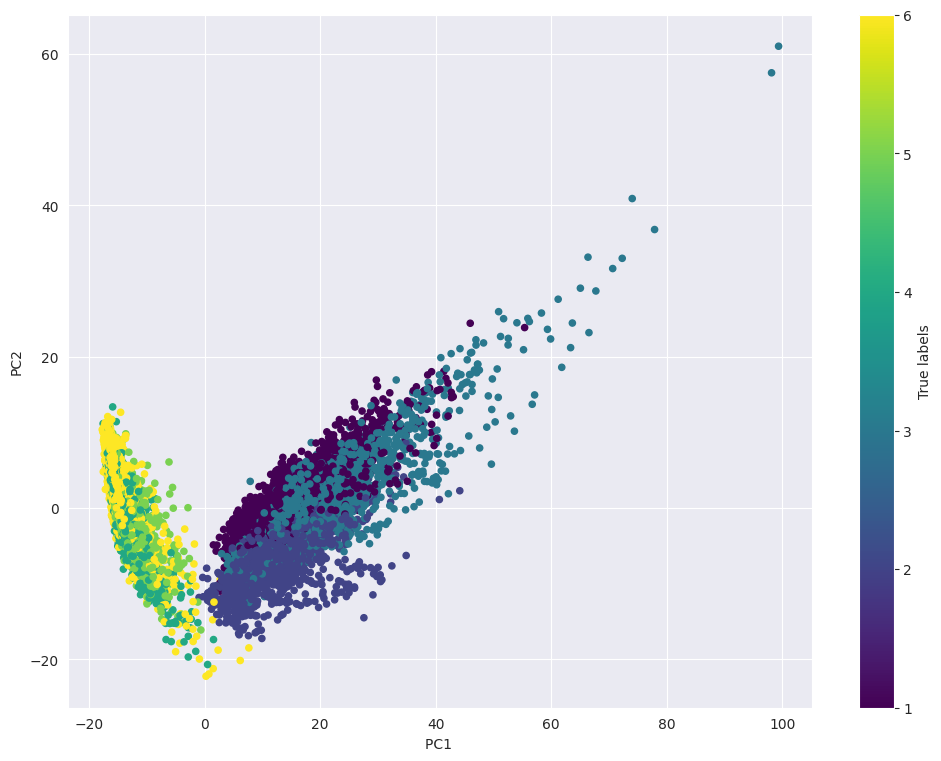

In [12]:
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0],
            X_pca[:, 1],
            c=y,
            s=20,
            cmap='viridis');
plt.xlabel('PC1 ')
plt.ylabel('PC2')
plt.colorbar(label='True labels')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
**- 6 кластеров**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [13]:
from sklearn.cluster import KMeans

k_means = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
cluster_labels = k_means.fit_predict(X_pca)
centroids_sklearn = k_means.cluster_centers_

print("Inertia:", k_means.inertia_)

Inertia: 2003454.8999158153


In [14]:
import numpy as np


def kmeansManual(X, n_clusters, n_init=10, max_iter=300, tol=1e-4):
    best_inertia = np.inf
    best_labels = None
    best_centroids = None

    for init_no in range(n_init):
        index = np.random.choice(X.shape[0], n_clusters, replace=False)
        centroids = X[index].copy()

        for iteration in range(max_iter):
            distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
            labels = np.argmin(distances, axis=1)

            new_centorids = np.array([
                X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k]
                for k in range(n_clusters)
            ])

            shift = np.linalg.norm(new_centorids - centroids, axis=1).max()
            centroids = new_centorids
            if shift < tol:
                break
        inertia = sum(((X[labels == k] - centroids[k]) ** 2).sum() for k in range(n_clusters))

        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centroids = centroids.copy()
    return best_labels, best_centroids, best_inertia


cluster_labels_custom, centroids_custom, inertia_custom = kmeansManual(
    X_pca,
    n_clusters=n_classes,
    n_init=100,
    max_iter=300,
    tol=1e-4
)

print("KMeans inertia:", inertia_custom)

KMeans inertia: 2003454.7982992886


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

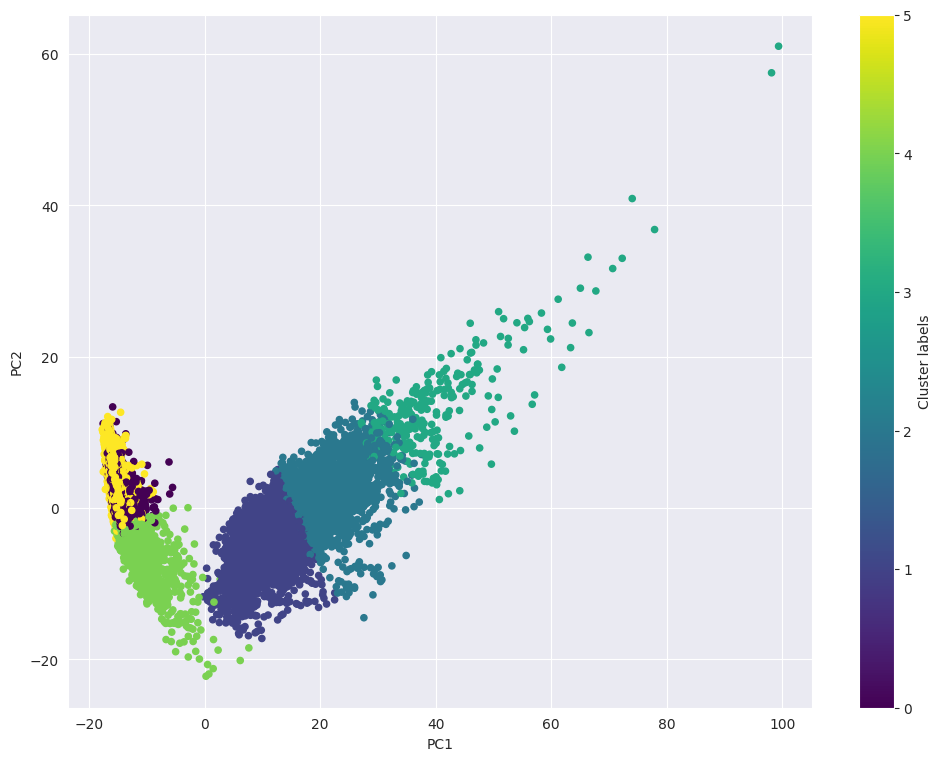

In [15]:
plt.figure(figsize=(12, 9))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    s=20,
    cmap='viridis');
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster labels')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [16]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

In [17]:
cluster_counts = tab.iloc[:-1, :-1]

total_per_class = tab['все'][:-1]

best_frac_per_class = cluster_counts.div(total_per_class, axis=0).max(axis=1)

best_activity = best_frac_per_class.idxmax()
best_value    = best_frac_per_class.max()

print(f"Best activity: «{best_activity}» with percent {best_value:.2%}")

Best activity: «подъем вверх по лестнице» with percent 80.38%


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████| 6/6 [01:31<00:00, 15.26s/it]


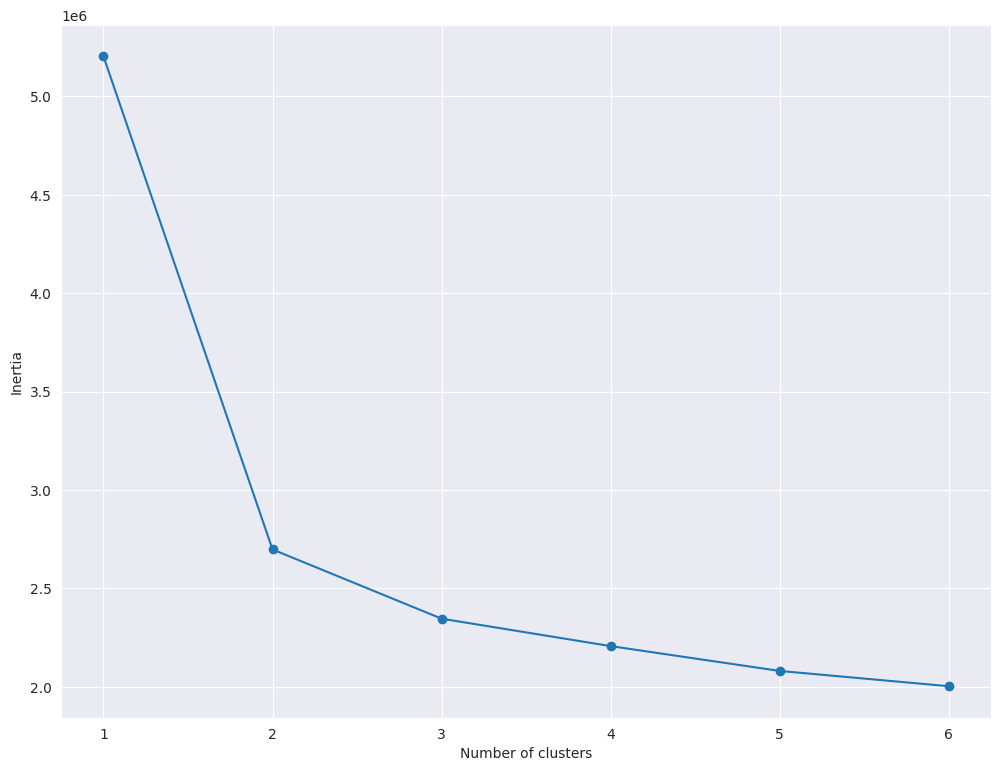

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

inertia = []
ks = range(1, n_classes + 1)
for k in tqdm(ks):
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=RANDOM_STATE
    )
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 9))
plt.plot(ks, inertia, marker='o')
plt.xticks(ks)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

In [19]:
xs = np.array(ks)
ys = np.array(inertia)

p1 = np.array([xs[0], ys[0]])
p2 = np.array([xs[-1], ys[-1]])

v = p2 - p1

distances = np.abs(
    v[1] * (xs - p1[0]) -
    v[0] * (ys - p1[1])
) / np.linalg.norm(v)

opt_k = xs[np.argmax(distances)]
print(f"Optimal: {opt_k}")

Optimal: 2


------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [20]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)
labels_ag = ag.labels_

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [21]:
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
).fit(X_pca)
labels_km = kmeans.labels_

ari_ag = adjusted_rand_score(y, labels_ag)
ari_km = adjusted_rand_score(y, labels_km)
print(f"Agglomerative: {ari_ag:.4f}")
print(f"Means:        {ari_km:.4f}")

Agglomerative: 0.4936
Means:        0.4198


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [24]:
grid = GridSearchCV(
    estimator=svc,
    param_grid=svc_params,
    cv=3,
    n_jobs=-1,
)
grid.fit(X_train_scaled, y_train)
best_svc = grid.best_estimator_
best_score_orig = grid.best_score_

/home/sergey/PycharmProjects/ML_UNI/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sergey/PycharmProjects/ML_UNI/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sergey/PycharmProjects/ML_UNI/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
print("Best params:", grid.best_params_)
print("CV-accuracy on train:", grid.best_score_)
print("Accuracy on test:   ", best_svc.score(X_test_scaled, y_test))

Best params: {'C': 0.1}
CV-accuracy on train: 0.9379785010699506
Accuracy on test:    0.9619952494061758


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [26]:
y_predicted = best_svc.predict(X_test_scaled)

In [27]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

- **Ни один**

In [28]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

activity_names = [
    'ходьба',
    'подъем вверх по лестнице',
    'спуск по лестнице',
    'сидение',
    'стояние',
    'лежание'
]

precision = precision_score(y_test, y_predicted, labels=np.arange(1, 7), average=None)
recall    = recall_score(   y_test, y_predicted, labels=np.arange(1, 7), average=None)

worst_prec_idx = np.argmin(precision)
worst_rec_idx  = np.argmin(recall)

print(f"по точности – {activity_names[worst_prec_idx]}")
print(f"по полноте   – {activity_names[worst_rec_idx]}")

по точности – стояние
по полноте   – сидение


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [29]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
Xtrain_pca = pca.fit_transform(X_train_scaled)
Xtest_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state=RANDOM_STATE, max_iter=1000)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1
)

grid.fit(Xtrain_pca, y_train)

best_score_pca = grid.best_score_
best_svc_pca = grid.best_estimator_

diff_percent = round((best_score_orig - best_score_pca) * 100)
print(f"  Best C:        {grid.best_params_['C']}")
print(f"  CV-accuracy:     {grid.best_score_:.4f}")
print(f"  Test accuracy:   {best_svc_pca.score(Xtest_pca, y_test):.4f}")
print(f"Difference in quality CV: {diff_percent}%")

  Best C:        0.1
  CV-accuracy:     0.8984
  Test accuracy:   0.9192
Difference in quality CV: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

chosen eps (k-dist): 43.23


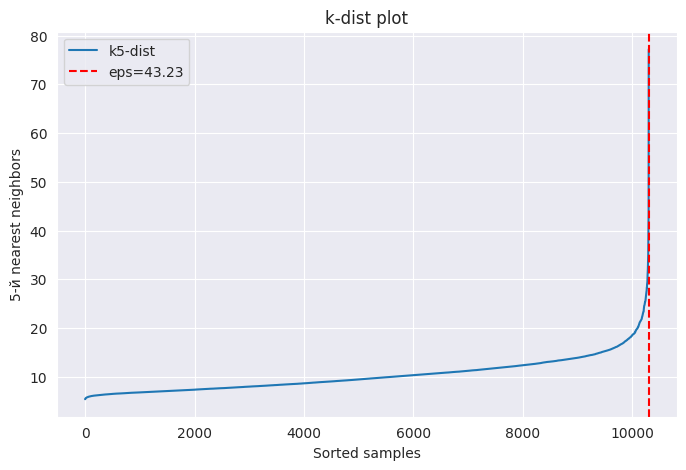

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5).fit(X_pca)
dists, _ = nn.kneighbors(X_pca)
k5 = np.sort(dists[:, 4])

d1 = np.gradient(k5)
d2 = np.gradient(d1)
idx_elbow = np.argmax(d2)
eps_choice = k5[idx_elbow]
print(f"chosen eps (k-dist): {eps_choice:.2f}")

plt.figure(figsize=(8,5))
plt.plot(k5, label='k5-dist')
plt.axvline(idx_elbow, color='red', linestyle='--', label=f'eps={eps_choice:.2f}')
plt.legend()
plt.title('k-dist plot')
plt.ylabel('5-й nearest neighbors')
plt.xlabel('Sorted samples')
plt.show()

DBSCAN cluster counts: Counter({np.int64(0): 9661, np.int64(-1): 573, np.int64(1): 45, np.int64(5): 11, np.int64(4): 4, np.int64(3): 3, np.int64(2): 2})


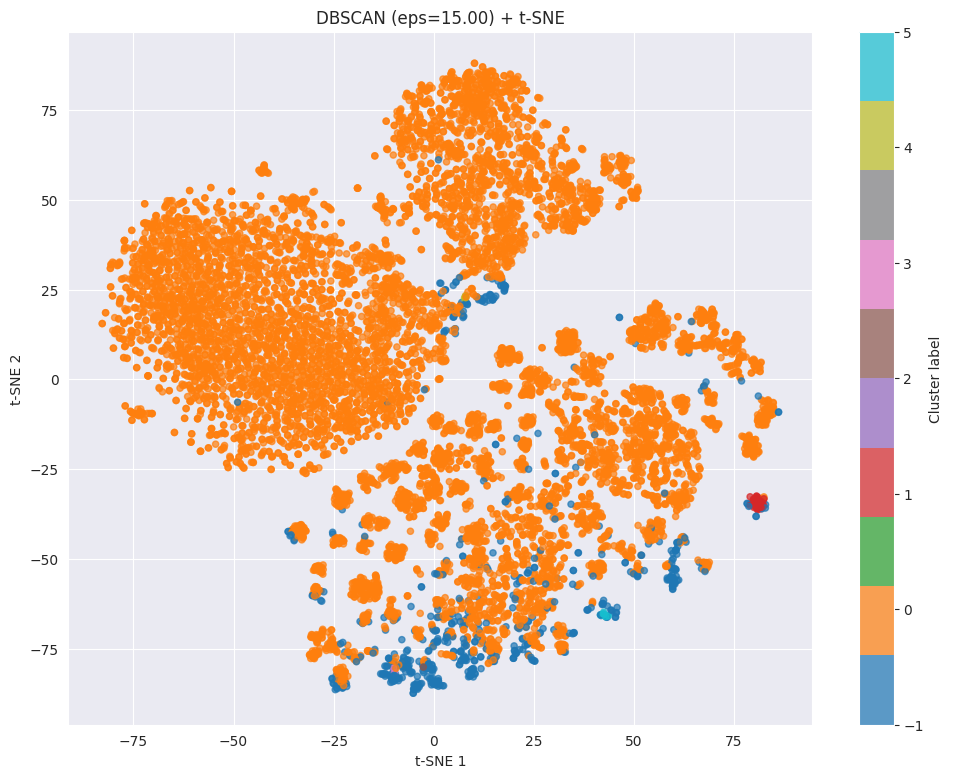

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from collections import Counter

db = DBSCAN(eps=15, min_samples=5).fit(X_pca)
print("DBSCAN cluster counts:", Counter(db.labels_))

X_tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init='random').fit_transform(X_pca)

plt.figure(figsize=(12, 9))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=db.labels_,
    cmap='tab10',
    s=20,
    alpha=0.7
)
plt.colorbar(label='Cluster label')
plt.title(f'DBSCAN (eps={15:.2f}) + t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


Оно при всех epsilon выдает либо единственный кластер либо почти единственный